<a href="https://colab.research.google.com/github/zerokinetic/preventing-brigading-in-reddit/blob/main/notebooks/data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
  import pandas as pd

df_title = pd.read_csv("/content/drive/MyDrive/sna/Preventing-Brigading-in-Reddit/dataset/soc-redditHyperlinks-title.tsv", sep='\t')
df_body = pd.read_csv("/content/drive/MyDrive/sna/Preventing-Brigading-in-Reddit/dataset/soc-redditHyperlinks-body.tsv", sep='\t')

In [ ]:
df = pd.concat([df_title, df_body])

In [ ]:
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
min_date = df['TIMESTAMP'].min()
print("Start date of dataset:", min_date)

Start date of dataset: 2013-12-31 16:20:20


In [ ]:
end_date = min_date + pd.DateOffset(months=1)

In [ ]:
df1 = df[(df['TIMESTAMP'] >= min_date) & (df['TIMESTAMP'] < end_date)]

print("Entries in first 1 month:", len(df1))

Entries in first 1 month: 13662


In [ ]:
import networkx as nx
G = nx.DiGraph()

In [ ]:
for _, row in df1.iterrows():
    src = row['SOURCE_SUBREDDIT']
    tgt = row['TARGET_SUBREDDIT']
    sentiment = row['LINK_SENTIMENT']
    timestamp = row['TIMESTAMP']

    # If edge already exists, accumulate weights (frequency + sentiment sum)
    if G.has_edge(src, tgt):
        G[src][tgt]['count'] += 1
        G[src][tgt]['sentiment_sum'] += sentiment
        G[src][tgt]['timestamps'].append(timestamp)
    else:
        G.add_edge(src, tgt, count=1, sentiment_sum=sentiment, timestamps=[timestamp])

In [ ]:
for u, v, data in G.edges(data=True):
    data['sentiment_avg'] = data['sentiment_sum'] / data['count']

# A. Degree Centrality

In [ ]:
deg_centrality = nx.degree_centrality(G)

# B. Betweenness Centrality

In [ ]:
btw_centrality = nx.betweenness_centrality(G, weight='count')

# C. Eigenvector Centrality

In [ ]:
# Extract largest strongly connected component
largest_cc = max(nx.strongly_connected_components(G), key=len)
subG = G.subgraph(largest_cc).copy()

eig_centrality = nx.eigenvector_centrality(subG, weight='count')

# A. Clustering Coefficient

In [ ]:
# For directed graphs, convert to undirected version
clustering = nx.clustering(G.to_undirected())

# B. Community Modularity (Louvain)

In [ ]:
# Install community detection package first
!pip install python-louvain

import community as community_louvain

# Run community detection on undirected version
undirected_G = G.to_undirected()
partition = community_louvain.best_partition(undirected_G, weight='count')

# partition is a dict: node -> community id

# C. Average Path Length (only on largest component to avoid disconnected graph issues)

In [ ]:
avg_path_length = nx.average_shortest_path_length(subG)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

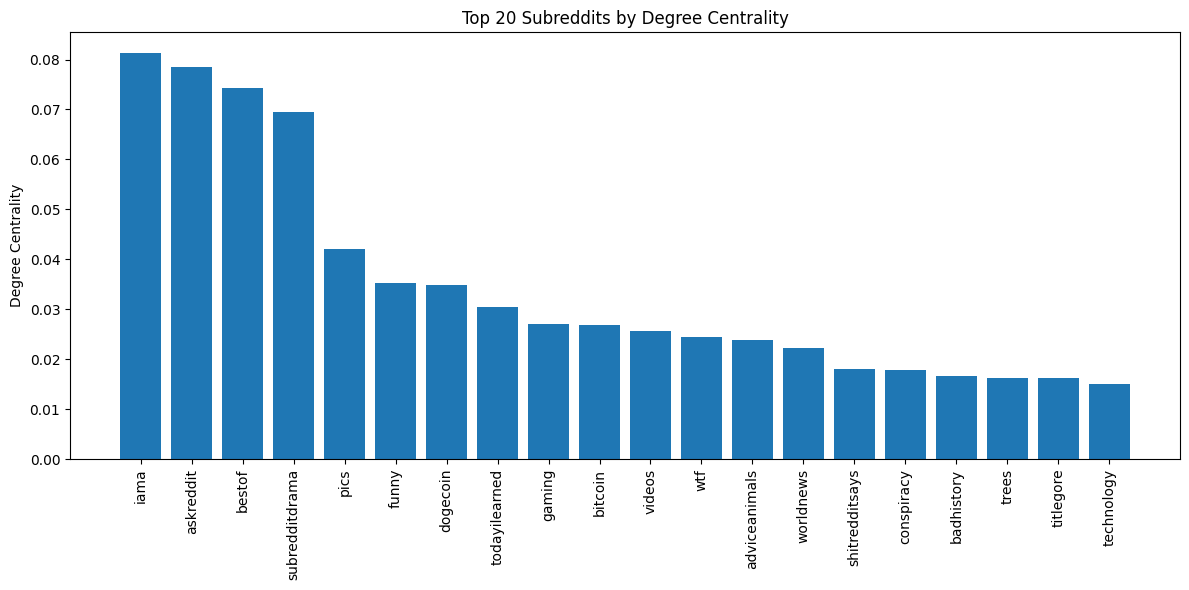

In [ ]:
# Degree Centrality
deg_centrality_sorted = sorted(deg_centrality.items(), key=lambda item: item[1], reverse=True)
top_n = 20  # Adjust based on how many top nodes you want to visualize
labels, values = zip(*deg_centrality_sorted[:top_n])
plt.figure(figsize=(12, 6))
plt.bar(labels, values)
plt.xticks(rotation=90)
plt.title('Top 20 Subreddits by Degree Centrality')
plt.ylabel('Degree Centrality')
plt.tight_layout()
plt.show()

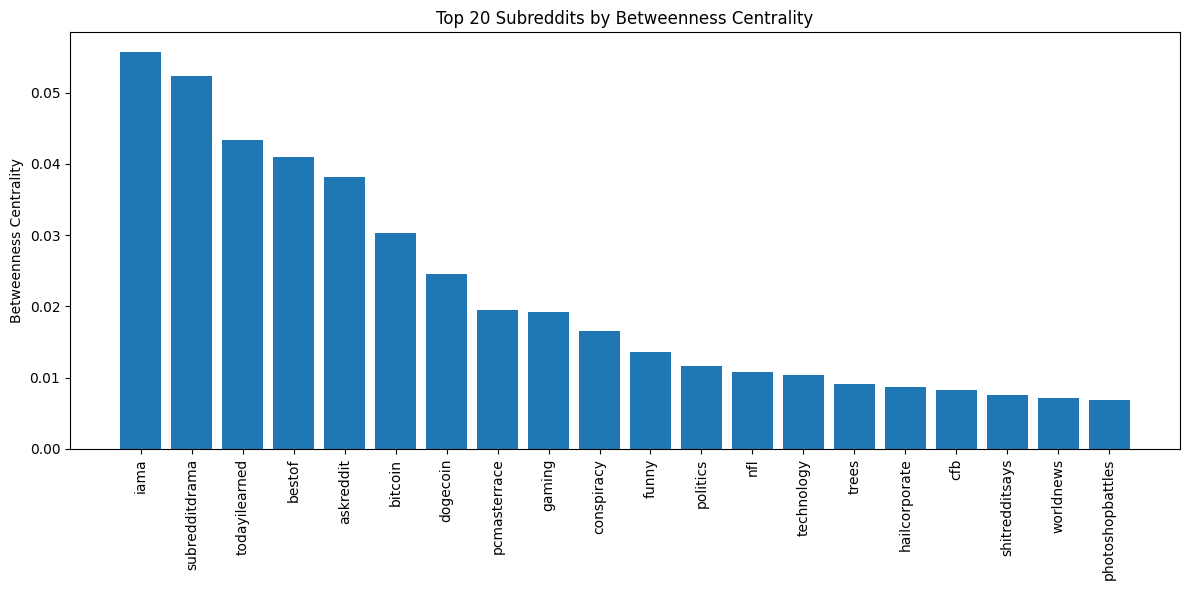

In [ ]:
# Betweenness Centrality
btw_centrality_sorted = sorted(btw_centrality.items(), key=lambda item: item[1], reverse=True)
labels, values = zip(*btw_centrality_sorted[:top_n])
plt.figure(figsize=(12, 6))
plt.bar(labels, values)
plt.xticks(rotation=90)
plt.title('Top 20 Subreddits by Betweenness Centrality')
plt.ylabel('Betweenness Centrality')
plt.tight_layout()
plt.show()

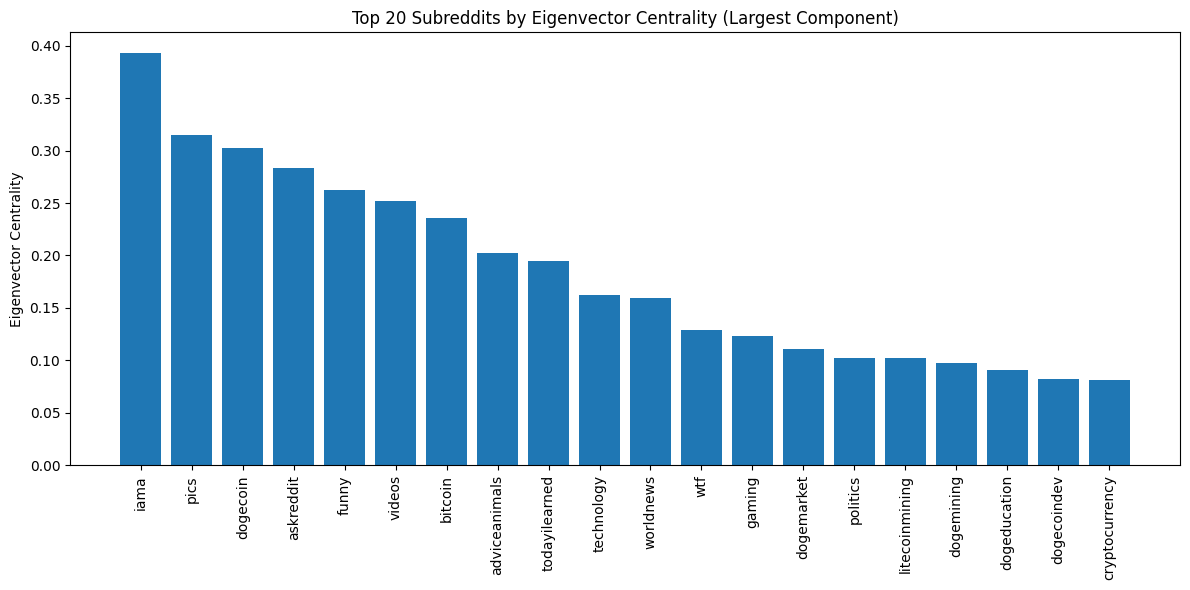

In [ ]:
# Eigenvector Centrality
# Ensure the nodes in eig_centrality match the nodes in subG
eig_centrality_filtered = {node: eig_centrality[node] for node in subG.nodes() if node in eig_centrality}
eig_centrality_sorted = sorted(eig_centrality_filtered.items(), key=lambda item: item[1], reverse=True)
labels, values = zip(*eig_centrality_sorted[:top_n])
plt.figure(figsize=(12, 6))
plt.bar(labels, values)
plt.xticks(rotation=90)
plt.title('Top 20 Subreddits by Eigenvector Centrality (Largest Component)')
plt.ylabel('Eigenvector Centrality')
plt.tight_layout()
plt.show()

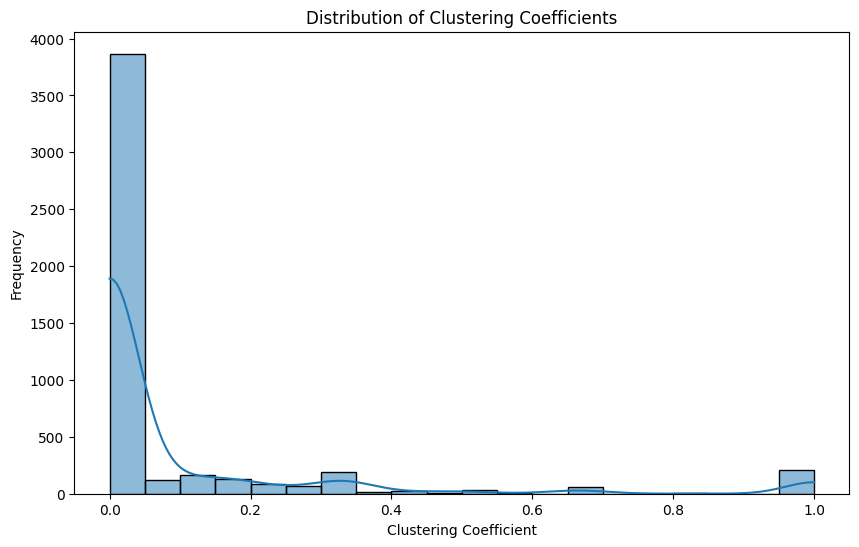

In [ ]:
# Convert clustering dictionary to a list of values
clustering_values = list(clustering.values())
plt.figure(figsize=(10, 6))
sns.histplot(clustering_values, bins=20, kde=True)
plt.title('Distribution of Clustering Coefficients')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Plotting Community Structure
#Get community assignments and counts
community_sizes = {}
for node, community_id in partition.items():
    if community_id not in community_sizes:
        community_sizes[community_id] = 0
    community_sizes[community_id] += 1

In [ ]:
# Sort communities by size
community_sizes_sorted = sorted(community_sizes.items(), key=lambda item: item[1], reverse=True)

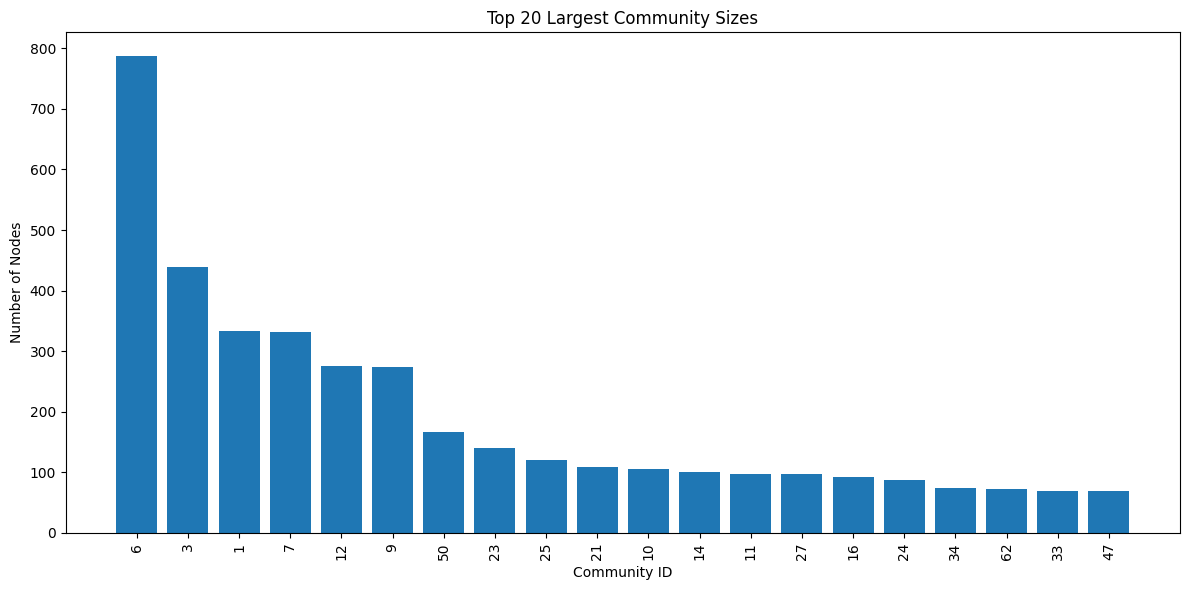

In [ ]:
# Plotting distribution of community sizes (e.g., top N communities)
top_n_communities = 20 # Adjust based on how many communities you want to visualize
community_labels, community_counts = zip(*community_sizes_sorted[:top_n_communities])

plt.figure(figsize=(12, 6))
plt.bar([str(label) for label in community_labels], community_counts) # Convert community IDs to strings for plotting
plt.xticks(rotation=90)
plt.title('Top 20 Largest Community Sizes')
plt.xlabel('Community ID')
plt.ylabel('Number of Nodes')
plt.tight_layout()
plt.show()

In [ ]:
sampled_nodes = list(G.nodes())
subgraph_for_viz = G.subgraph(sampled_nodes)

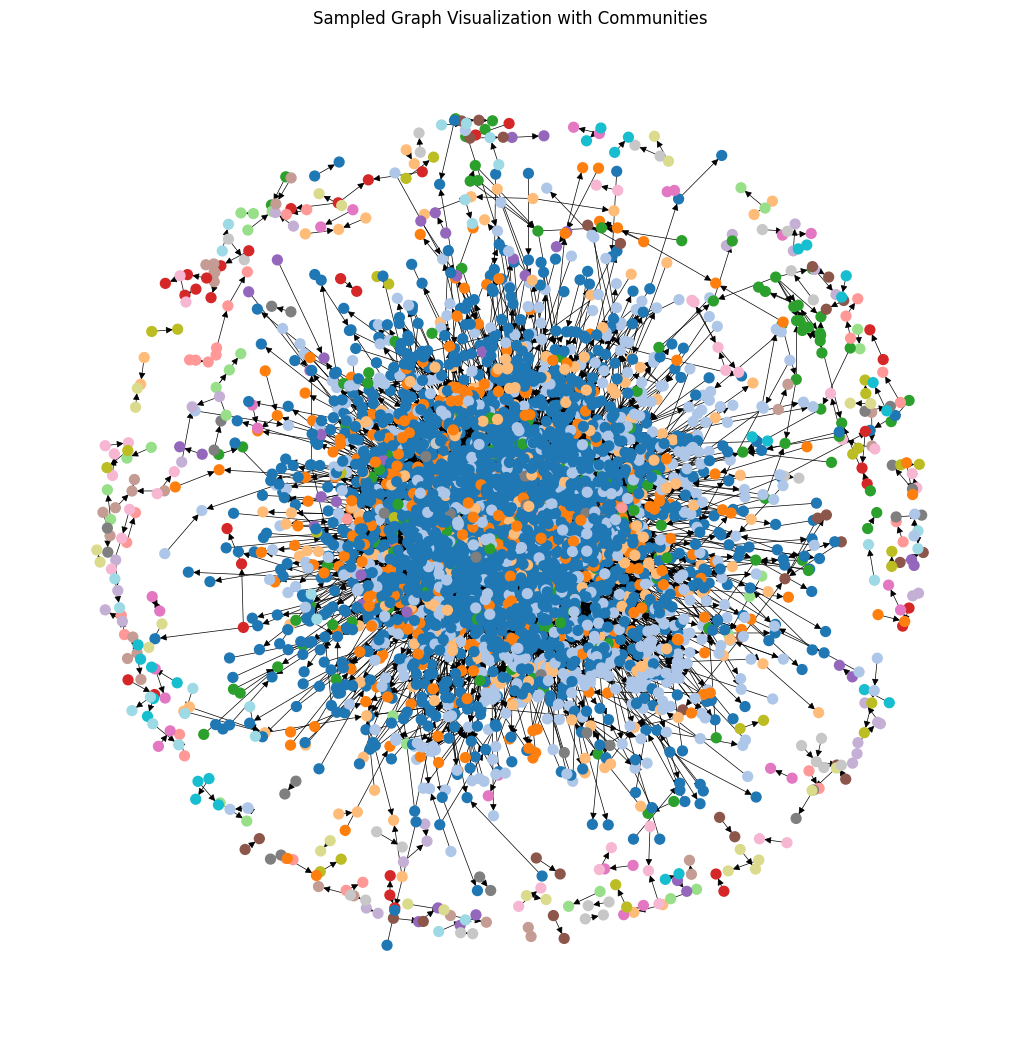

In [ ]:
node_colors = [partition[node] for node in subgraph_for_viz.nodes()]

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(subgraph_for_viz, seed=42)  # Layout algorithm
nx.draw(subgraph_for_viz, pos, node_color=node_colors, with_labels=False, node_size=50, width=0.5, cmap=plt.cm.tab20)
plt.title('Sampled Graph Visualization with Communities')
plt.show()

In [ ]:
print(f"Average Path Length (Largest Component): {avg_path_length:.2f}")

Average Path Length (Largest Component): 4.63


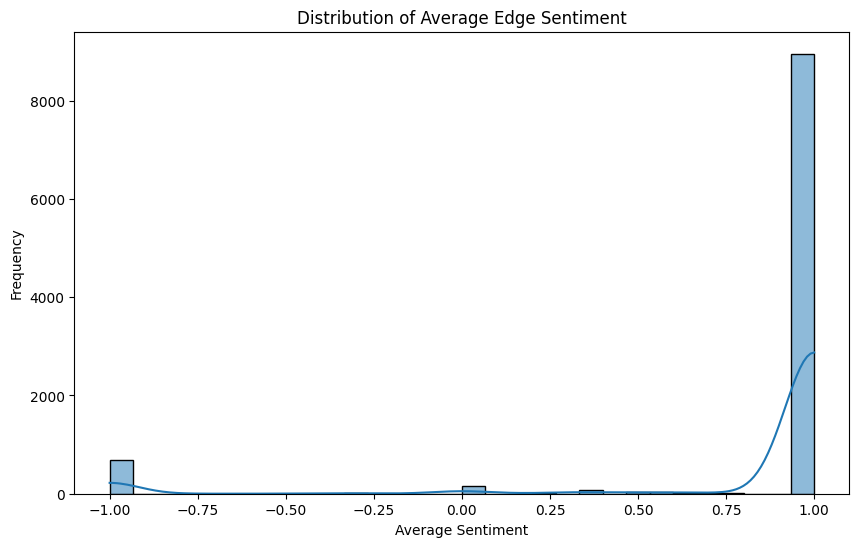

In [ ]:
# Plotting Edge Sentiment Distribution

# Extract average sentiment from edges
sentiment_values = [data['sentiment_avg'] for u, v, data in G.edges(data=True)]

plt.figure(figsize=(10, 6))
sns.histplot(sentiment_values, bins=30, kde=True)
plt.title('Distribution of Average Edge Sentiment')
plt.xlabel('Average Sentiment')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Plotting Edge Count Distribution

# Extract edge counts
edge_counts = [data['count'] for u, v, data in G.edges(data=True)]

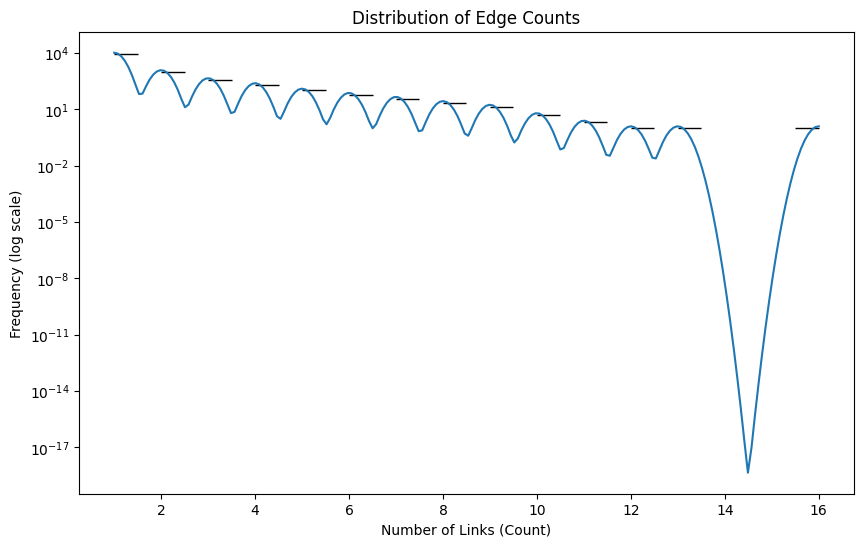

In [ ]:
# Plotting Edge Count Distribution

# Extract edge counts
edge_counts = [data['count'] for u, v, data in G.edges(data=True)]

plt.figure(figsize=(10, 6))
sns.histplot(edge_counts, bins=30, kde=True, log_scale=(False, True)) # Log scale for y-axis often helpful for counts
plt.title('Distribution of Edge Counts')
plt.xlabel('Number of Links (Count)')
plt.ylabel('Frequency (log scale)')
plt.show()

In [ ]:
df1.to_csv("1month.csv", index=False)
print("saved first 1 month data to '1month.csv'")

saved first 1 month data to '1month.csv'
